In [ ]:
# Ensure deps are available in this environment
!uv pip install --quiet flax==0.12.1 jax==0.8.1 jaxlib==0.8.1 optax==0.2.6 matplotlib>=3.8.0 git+https://github.com/wchen99998/local_sampler.git


# Locally Tilted Sampler — Training Flow Walkthrough

Live loss plotting per time slice using `LiveLossPlot`.

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import jax
import jax.numpy as jnp
import numpy as np
import dataclasses as dc
import matplotlib.pyplot as plt


from locally_tilted_sampler import (
    FlowDimensions,
    GaussianDensity,
    TrainingConfig,
    make_gmm9,
    make_gmm40,
    plot_density,
    print_parameter_counts,
    train_locally_tilted_sampler,
    LiveLossPlot,
)
from locally_tilted_sampler.segment_flow_matching import compute_weighted_loss
from locally_tilted_sampler.flow import FlowMLP
import flax.nnx as nnx


## 1) Densities
Set prior/target and inspect log probs.

In [3]:
prior = GaussianDensity.from_mean_cov([0.0, 0.0], [[1.5**2, 0.0], [0.0, 1.5**2]])
target = make_gmm9(scale=3.0, std=0.35)
x_demo = jnp.array([[0.0, 0.0], [2.0, -1.0]])
prior.log_prob(x_demo), target.log_prob(x_demo)


(Array([-2.6488073, -3.7599185], dtype=float32),
 Array([ 0.26176715, -7.9014883 ], dtype=float32))

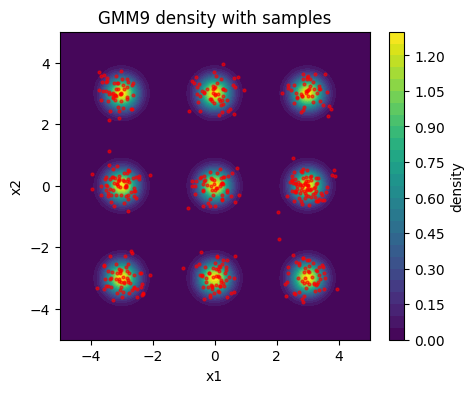

In [4]:
samples = target.sample(jax.random.PRNGKey(0), (512,))
fig, ax = plot_density(target.log_prob, bounds=(-5, 5), n_points=150, samples=samples)
ax.set_title('GMM9 density with samples')
plt.show()


## 2) Flow model (NNX)

In [5]:
flow_dims = FlowDimensions(dim=2, hidden=64, depth=2)
flow = FlowMLP(flow_dims, rngs=nnx.Rngs(0))
print_parameter_counts(flow, module_name='FlowMLP', max_depth=3)


Parameter Count Analysis: FlowMLP

FlowMLP                 21,378 params    100.0%  [██████████████████████████████]
├── ff1                  8,320 params     38.9%  [███████████░░░░░░░░░░░░░░░░░░░]
├── ff2                  8,320 params     38.9%  [███████████░░░░░░░░░░░░░░░░░░░]
├── input                4,288 params     20.1%  [██████░░░░░░░░░░░░░░░░░░░░░░░░]
├── norm1                  128 params      0.6%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
├── norm2                  128 params      0.6%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
├── output                 130 params      0.6%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
└── output_norm             64 params      0.3%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]

────────────────────────────────────────────────────────────────────────────────
TOTAL                   21,378 params  100.0%

Summary Statistics (depth=1 modules):
  - Number of modules: 7
  - Largest module: 8,320 params
  - Smallest module: 64 params
  - Average module: 3,054 params



## 3) Loss sample

In [6]:
key = jax.random.PRNGKey(1)
x_ts = target.sample(key, (16,))
x_te = x_ts + 0.1 * jax.random.normal(key, x_ts.shape)
loss = compute_weighted_loss(flow, key, x_ts, x_te)
loss


Array(2.79542, dtype=float32)

## 4) Training with live loss (per time slice figure)

Parameter Count Analysis: Flow

Flow                    21,378 params    100.0%  [██████████████████████████████]
├── ff1                  8,320 params     38.9%  [███████████░░░░░░░░░░░░░░░░░░░]
├── ff2                  8,320 params     38.9%  [███████████░░░░░░░░░░░░░░░░░░░]
├── input                4,288 params     20.1%  [██████░░░░░░░░░░░░░░░░░░░░░░░░]
├── norm1                  128 params      0.6%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
├── norm2                  128 params      0.6%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
├── output                 130 params      0.6%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]
└── output_norm             64 params      0.3%  [░░░░░░░░░░░░░░░░░░░░░░░░░░░░░░]

────────────────────────────────────────────────────────────────────────────────
TOTAL                   21,378 params  100.0%

Summary Statistics (depth=1 modules):
  - Number of modules: 7
  - Largest module: 8,320 params
  - Smallest module: 64 params
  - Average module: 3,054 params

[time slice start] t=0

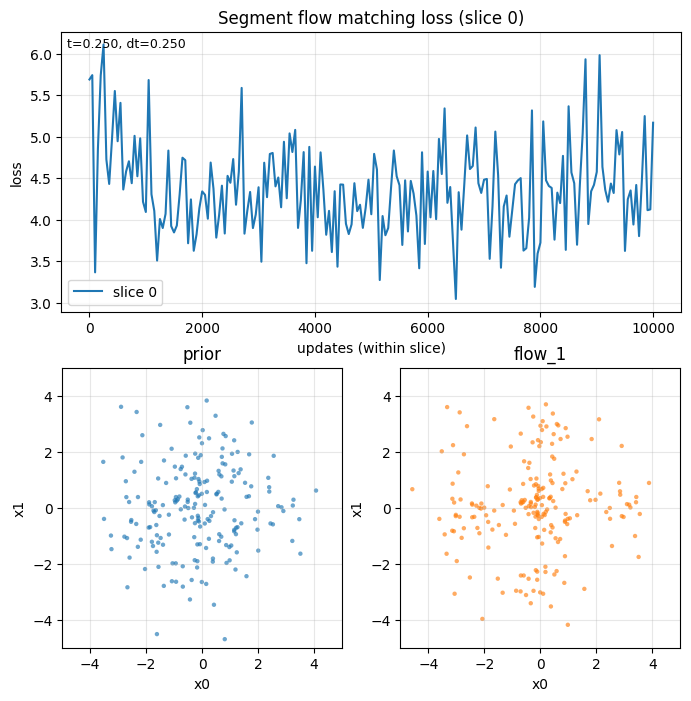

[time slice end]  t=0.2500, loss=5.170171
[time slice start] t=0.2500, delta_t=0.2500, samples=10240


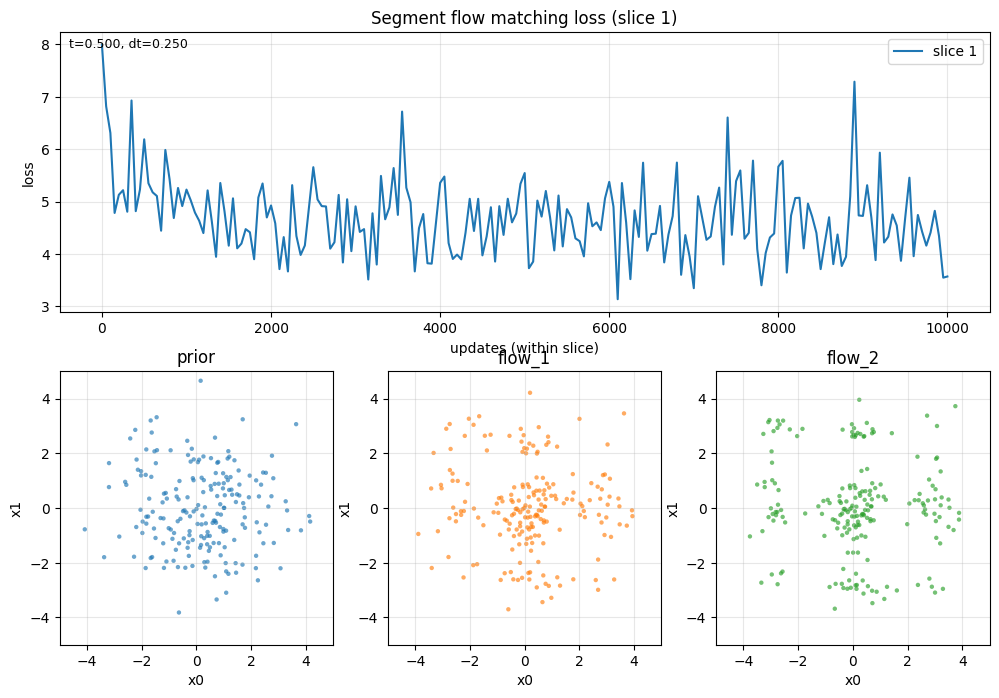

[time slice end]  t=0.5000, loss=3.570274
[time slice start] t=0.5000, delta_t=0.2500, samples=10240


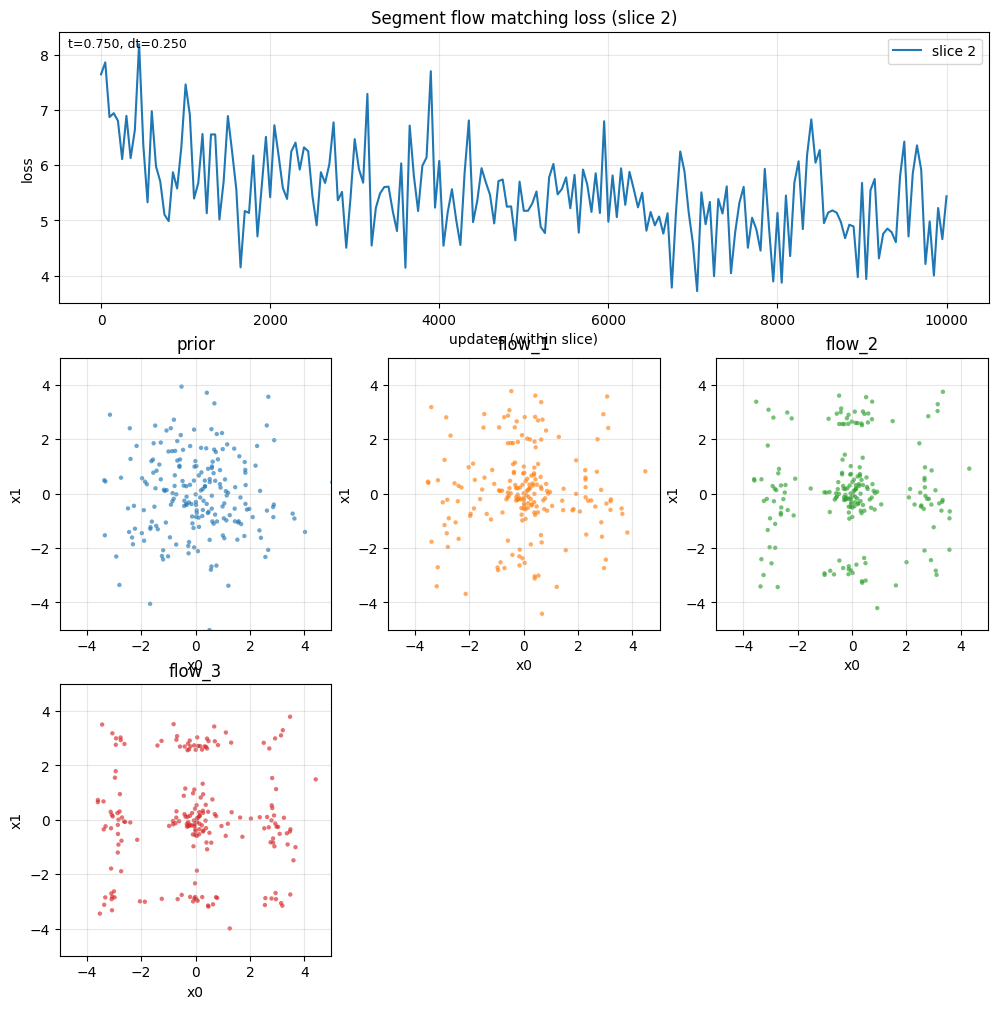

[time slice end]  t=0.7500, loss=5.439081
[time slice start] t=0.7500, delta_t=0.2500, samples=10240


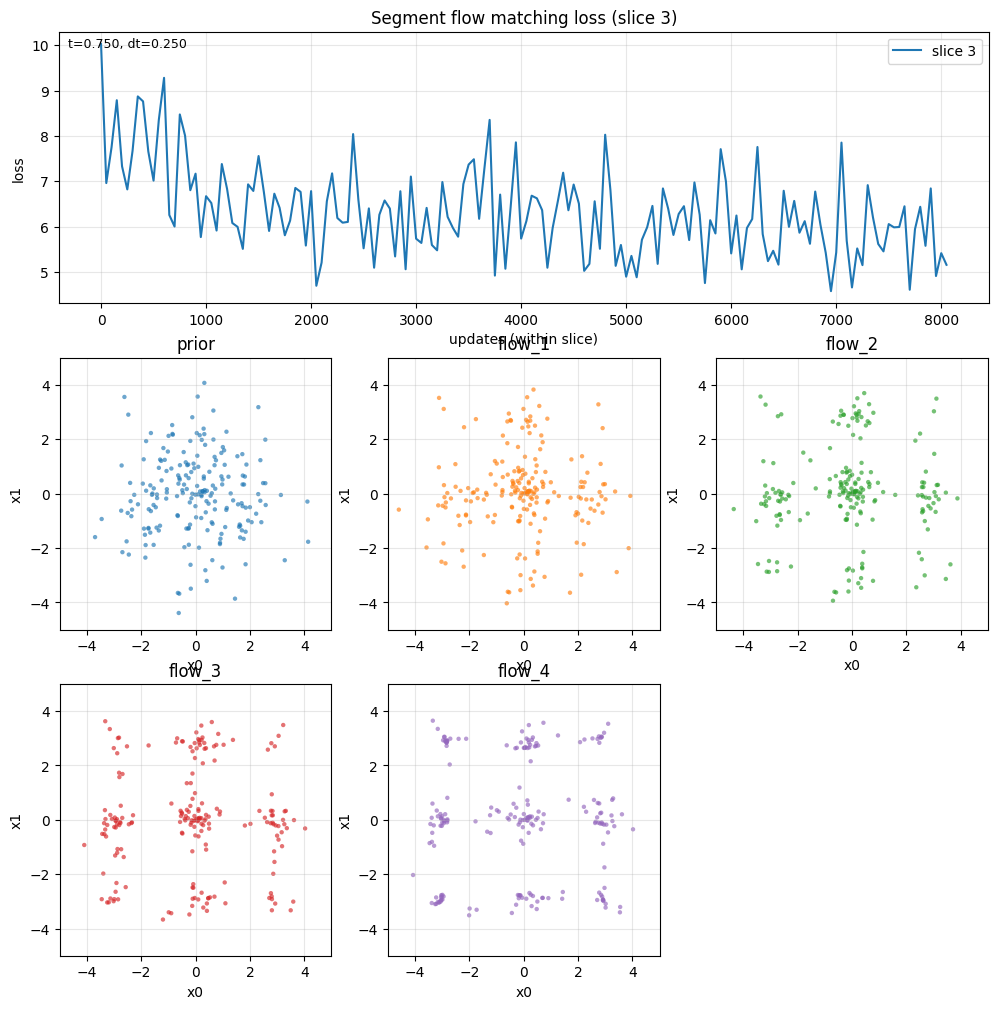

In [ ]:
mini_config = TrainingConfig(
    time_slices=4,
    solver_substeps=16,
    lr=3e-4,
    weight_decay=1e-4,
    max_updates=10000,
    train_samples=10240,
    train_batch_size=256,
    seed=42,
    use_ancestral_pairs=True,
    use_stratified_coupling=True,
    optimizer="muon",
    optimizer_kwargs={
        "adam_weight_decay": 1e-4,
    }
)

live = LiveLossPlot(title='Segment flow matching loss', per_slice=True)
mini_config = dc.replace(mini_config, loss_callback=live.update)

train_result = train_locally_tilted_sampler(
    flow_dims=FlowDimensions(dim=2, hidden=64, depth=2),
    prior=prior,
    target=target,
    config=mini_config,
)
train_result.loss_log


## 5) Final samples vs target

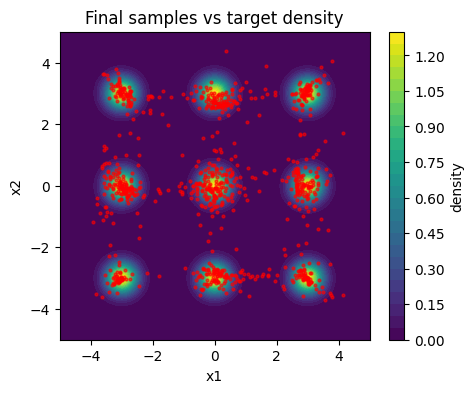

In [9]:
final_samples = jnp.array(train_result.final_samples)
fig, ax = plot_density(target.log_prob, bounds=(-5, 5), n_points=150, samples=final_samples[:1000])
ax.set_title('Final samples vs target density')
plt.show()
